## Predictive Modeling - Problem Definition
Our goal is to build a binary classification model to predict whether a delivery will be late, based solely on information available at the time of purchase.

Target variable: `is_late`  
Type: Binary Classification (0 = On time, 1 = Late)


### Data Loading


In [10]:
# Import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.parquet import to_parquet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [4]:
# Import dataframe
current_dir = os.getcwd()
data_path = os.path.abspath(os.path.join(current_dir, "..", "data", "processed"))
df_modeling = pd.read_parquet(os.path.join(data_path, "df_model.parquet"))



In [9]:
# Checking dataframe
df_modeling.columns.unique()

Index(['order_purchase_month_2017-01', 'order_purchase_month_2017-02',
       'order_purchase_month_2017-03', 'order_purchase_month_2017-04',
       'order_purchase_month_2017-05', 'order_purchase_month_2017-06',
       'order_purchase_month_2017-07', 'order_purchase_month_2017-08',
       'order_purchase_month_2017-09', 'order_purchase_month_2017-10',
       'order_purchase_month_2017-11', 'order_purchase_month_2017-12',
       'order_purchase_month_2018-01', 'order_purchase_month_2018-02',
       'order_purchase_month_2018-03', 'order_purchase_month_2018-04',
       'order_purchase_month_2018-05', 'order_purchase_month_2018-06',
       'order_purchase_month_2018-07', 'order_purchase_month_2018-08',
       'customer_state_AC', 'customer_state_AL', 'customer_state_AM',
       'customer_state_AP', 'customer_state_BA', 'customer_state_CE',
       'customer_state_DF', 'customer_state_ES', 'customer_state_GO',
       'customer_state_MA', 'customer_state_MG', 'customer_state_MS',
       'cu

In [7]:
df_modeling.head(5)

,order_purchase_month_2017-01,order_purchase_month_2017-02,order_purchase_month_2017-03,order_purchase_month_2017-04,order_purchase_month_2017-05,order_purchase_month_2017-06,order_purchase_month_2017-07,order_purchase_month_2017-08,order_purchase_month_2017-09,order_purchase_month_2017-10,...,distance_category_long,distance_category_medium,distance_category_short,product_volume,product_weight_g,freight_value,payment_value,price,estimated_time,is_late
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1976.0,500.0,8.72,18.12,29.99,15.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1976.0,500.0,8.72,2.00,29.99,15.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1976.0,500.0,8.72,18.59,29.99,15.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,4693.0,400.0,22.76,141.46,118.70,17.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,9576.0,420.0,19.22,179.12,159.90,26.0,0


In [8]:
df_modeling.isnull().sum()

order_purchase_month_2017-01    0
order_purchase_month_2017-02    0
order_purchase_month_2017-03    0
order_purchase_month_2017-04    0
order_purchase_month_2017-05    0
                               ..
freight_value                   0
payment_value                   0
price                           0
estimated_time                  0
is_late                         0
Length: 79, dtype: int64

In [13]:
# Feature Scaling
X = df_modeling.drop('is_late', axis=1)
y = df_modeling['is_late']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [15]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Model Comparison (Prioritizing Recall)
# We define and train several models to compare their performance with emphasis on correctly identifying late deliveries (high recall for class 1).
# Cross-validation is used with recall as the scoring metric.

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVM": SVC(class_weight='balanced')
}

results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    cv_scores = cross_val_score(model, X_scaled, y, cv=skf, scoring='recall')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    results.append({
        "Model": name,
        "Recall (Late)": report['1']['recall'],
        "Precision (Late)": report['1']['precision'],
        "F1-score (Late)": report['1']['f1-score'],
        "CV Recall (mean)": cv_scores.mean()
    })

In [ ]:
# Results Table
# We present a comparison table showing Recall, Precision, and F1-score for class 1 (late deliveries),
# along with the average cross-validation Recall score to evaluate model robustness.

results_df = pd.DataFrame(results)
print(results_df.sort_values(by='Recall (Late)', ascending=False))


                 Model  Recall (Late)  Precision (Late)  F1-score (Late)  \
4                  SVM       0.721175          0.171681         0.277340   
0  Logistic Regression       0.715632          0.161153         0.263067   
1        Random Forest       0.233925          0.688418         0.349193   
3              XGBoost       0.119734          0.598338         0.199538   
2    Gradient Boosting       0.019956          0.580645         0.038585   

   CV Recall (mean)  
4          0.711562  
0          0.702803  
1          0.240771  
3          0.125153  
2          0.021062  


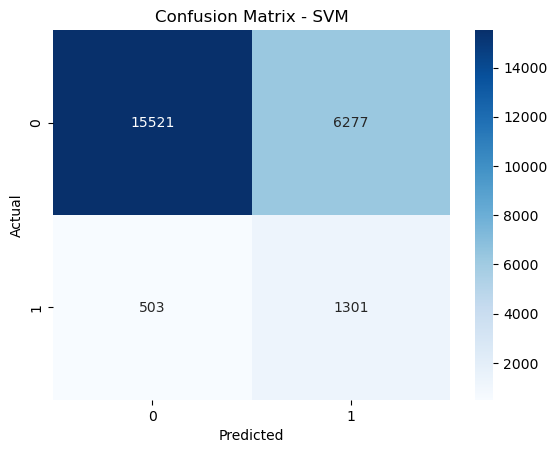

In [ ]:
# Confusion Matrix Example (Best Model)
# Here we visualize the confusion matrix of the best performing model based on recall: SVM.

best_model = SVC(class_weight='balanced')
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# GridSearch (SVM)
# Since SVM showed the highest recall, we now fine-tune it using GridSearchCV with a recall-focused evaluation.

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm = SVC(class_weight='balanced')
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=3, scoring='recall', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

print("Best parameters (SVM):", grid_search_svm.best_params_)
print("Best Recall (SVM):", grid_search_svm.best_score_)


Best parameters (SVM): {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best Recall (SVM): 0.7126227512761178


In [ ]:
# Alternative Strategy: Threshold Tuning (Random Forest)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf_base = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search_rf = GridSearchCV(rf_base, param_grid_rf, cv=3, scoring='recall', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print("Best parameters (RF):", grid_search_rf.best_params_)
print("Best Recall (RF):", grid_search_rf.best_score_)


Best parameters (RF): {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best Recall (RF): 0.6113325487390325


In [28]:
rf = grid_search_rf.best_estimator_
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, random_state=42)

In [ ]:
print(classification_report(y_test, y_pred_thresh))



Classification Report with Custom Threshold (0.30):
              precision    recall  f1-score   support

           0       0.96      0.79      0.87     21798
           1       0.20      0.63      0.30      1804

    accuracy                           0.78     23602
   macro avg       0.58      0.71      0.59     23602
weighted avg       0.90      0.78      0.82     23602



Although the SVM model reached the highest recall (72%), it had a very low precision (17%), which could cause excessive false alerts.
By applying a threshold-adjusted Random Forest, we reached a more balanced result with 63% recall and 20% precision — improving the overall F1-score.
This makes the model more practical for real-world applications where excessive false positives can lead to inefficiency or alert fatigue.